## Reinfection Propagation
This notebook contains the Pandemic Network that allows for mitigation and reinfection


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statistics
import random
import tqdm
import copy
from matplotlib.pyplot import cm


  0%|                                                    | 0/10 [00:00<?, ?it/s]

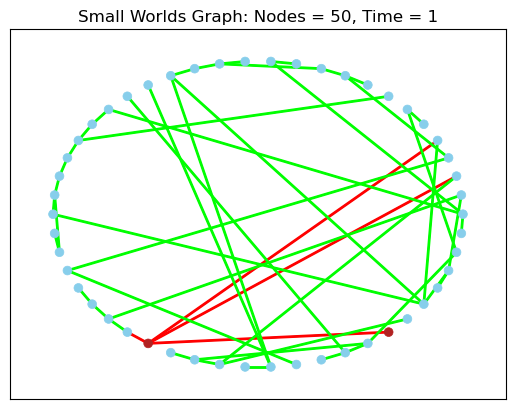

 10%|████▍                                       | 1/10 [00:00<00:01,  7.04it/s]

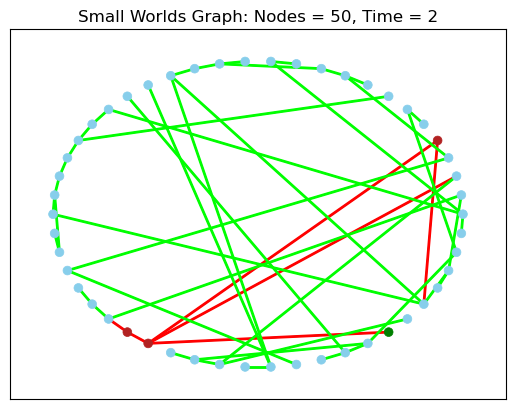

 20%|████████▊                                   | 2/10 [00:00<00:01,  7.73it/s]

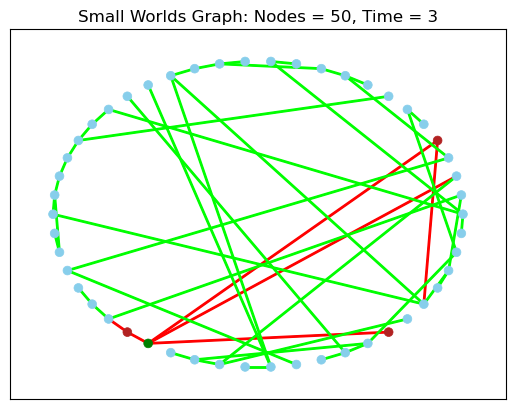

 30%|█████████████▏                              | 3/10 [00:00<00:00,  7.96it/s]

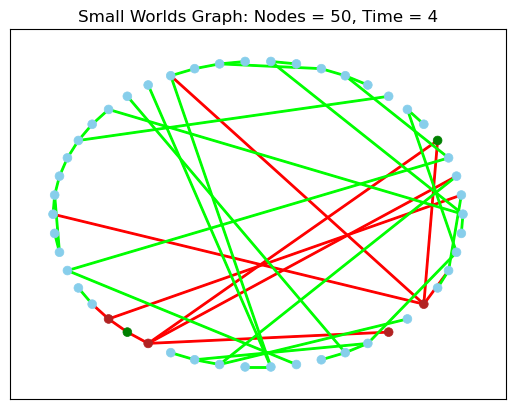

 40%|█████████████████▌                          | 4/10 [00:00<00:00,  8.05it/s]

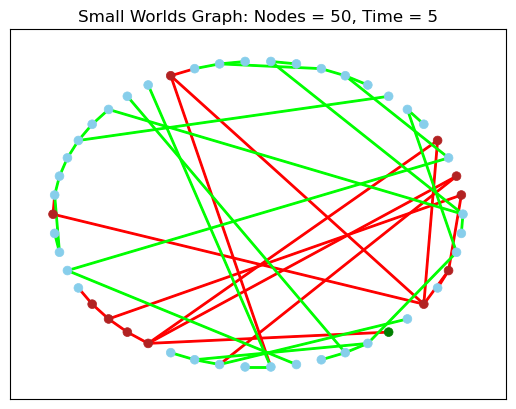

 50%|██████████████████████                      | 5/10 [00:00<00:00,  8.07it/s]

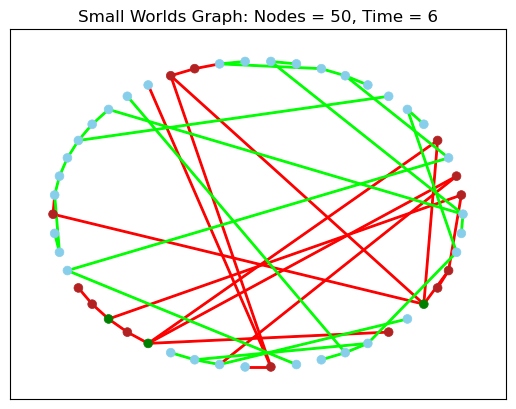

 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  8.23it/s]

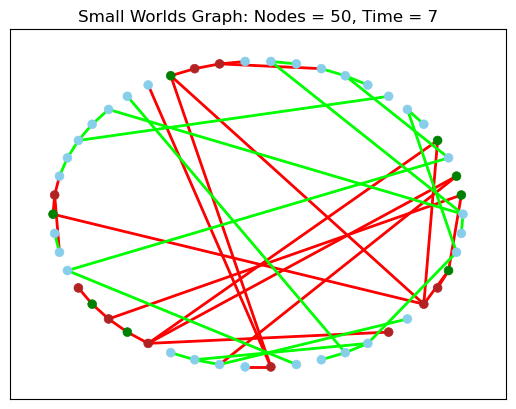

 70%|██████████████████████████████▊             | 7/10 [00:00<00:00,  8.30it/s]

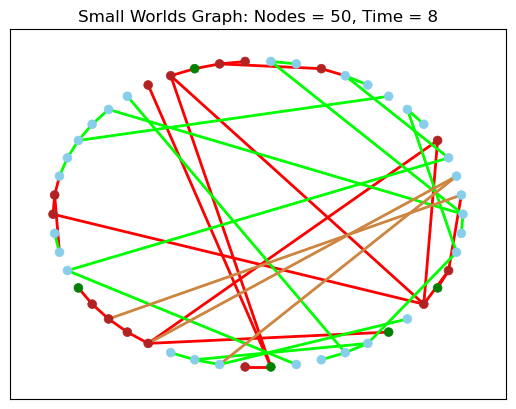

 80%|███████████████████████████████████▏        | 8/10 [00:01<00:00,  5.52it/s]

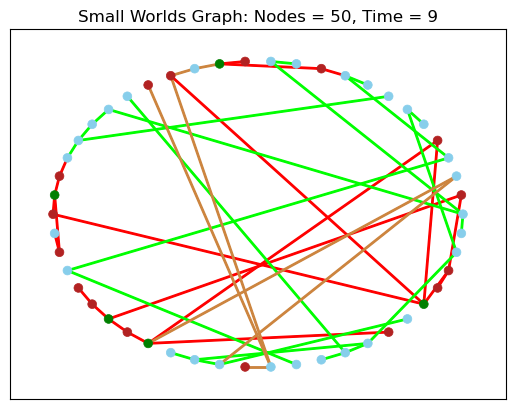

 90%|███████████████████████████████████████▌    | 9/10 [00:01<00:00,  6.23it/s]

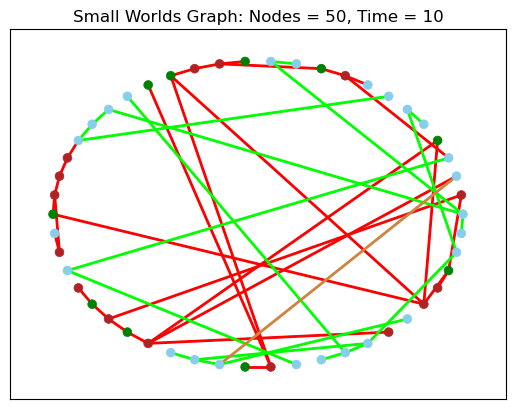

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.10it/s]


In [46]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, reduced_prob: float ,mitigation_proportion: float, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15):
        '''
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.p_reduced = reduced_prob # reduced probability of infection due to mitigation
        self.mit_prop = mitigation_proportion # proporation of the population that follows the mitigation
        self.want_plots = plots
        self.masked = []
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnodes
        # print(self.sicknodes)
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP  # - doesn't actually make sense reinfection can occur anytime after infection
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):

        node_colors = ["green" if node in self.recovered else 'magenta' if node in self.masked else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p_reduced]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # masked
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                for i in self.sicknodes:
                    if np.random.random() < self.mit_prop: # a proportion of initially sick nodes will adopt mitigation measures
                        self.masked.append(i)
                    else: 
                        pass
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.masked or j[1] in self.masked)  :
                        self.g.add_edge(j[0], j[1], weight = self.p_reduced) 
                    elif (j[0] in self.sicknodes or j[1] in self.sicknodes) and (j[0] not in self.masked or j[1] not in self.masked):
                        self.g.add_edge(j[0], j[1], weight = self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 

                # self.plot()
                
            else: 
                pass
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

            for i in range(len(list(self.g.nodes))):
                
                #Checking TTR
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    self.recovered.add(i)
                    nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                    nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    
                    
                #Checking NIP
                if self.g.nodes[i]['NIP'] -1 == 0:
                    self.recovered.remove(i)
                    neighbours = list(self.g.neighbors(i))
                    for n in neighbours:
                        self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                    if i in self.masked:
                        self.masked.remove(i)
                    else:
                        pass
                    nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value
                
                elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                    pass
                else:
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    

            
            for node in currentsick:
                neighbours = list(self.g.neighbors(node))

                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                        pass
                    elif np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                        self.sicknodes.add(neighbour)
                        adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                        new_sick += 1

                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                        if np.random.random() < self.mit_prop: # determine whether newly sick node will adopt mitigation measure
                            self.masked.append(neighbour)
                            for i in adj_neighbours:
                                self.g.add_edge(i, neighbour, weight = self.p_reduced) # mitigated probability of infection -> overwrite all edges

                        else: # node did not adopt mitigation measure 
                            for i in adj_neighbours: 
                                if self.g.get_edge_data(i,neighbour)['weight'] == self.p_reduced: # do not overwrite mitigated edges
                                    pass
                                else: 
                                    self.g.add_edge(i, neighbour, weight = self.p) # non-mitigated probability of infection.

                    else: # node not infected
                        pass
            
            self.Rt.append(new_sick/len(currentsick)) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
                
            
            #If no more sick nodes than we can finish propagation
            if len(self.sicknodes) == 0:
                break
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], self.Rt
    
    
# Testing the class
num_nodes = 50
num_sick = 2
avg_connection = 3
randomness = 0.5
TTR_val = 1
mit_prob = 0.1
mit_proportion = 0
NIP = 1
RP = 0.5
p = 0.6

G_data = Pandemic_Network(nodes = num_nodes, network_type = ntype, pandemicprob = p, reduced_prob = mit_prob, mitigation_proportion = mit_proportion, NIP = NIP, RP = i, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = True, TTR = TTR_val).propagate(10)


## Functions to average values in 2d and 3d list

In [2]:
def twodaverage(points: list[list]):
    mean_list = []
    std_list = []
    for i in range(len(points[0])):
        mean_list.append(np.mean([points[j][i] for j in range(len(points))]))
        std_list.append(np.std([points[j][i] for j in range(len(points))]))
        
    return mean_list, std_list


#First index is repeatitions, second index is probabilities, and third index is values to average over
def threedaverage(points: list[list[list]]):
    mean_list = []
    std_list = []
    for j in range(len(points[0])): # j index is for the probability
        maxl = max([len(points[k][j]) for k in range(len(points))]) 
        rtaverage = []
        rtstd = []
        for i in range(maxl): # i is index for the rt value
            avgpoints = []
            for k in range(len(points)):
                try:
                    avgpoints.append(points[k][j][i])
                except:
                    pass
                
            rtaverage.append(np.mean(avgpoints))
            rtstd.append(np.std(avgpoints))
                
        mean_list.append(rtaverage)
        std_list.append(rtstd)
            
    return mean_list, std_list


## R0 function

In [3]:
def theoretical_R0(average_edges: int, TTR: int, p: float):
    R0 = 0
    for i in range(TTR):
        R0 += average_edges *p
        average_edges -= average_edges *p
        
    return R0

print(theoretical_R0(6, 3, 0.1))


1.6260000000000001


## Affect on cummulative infected

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 32.44it/s]


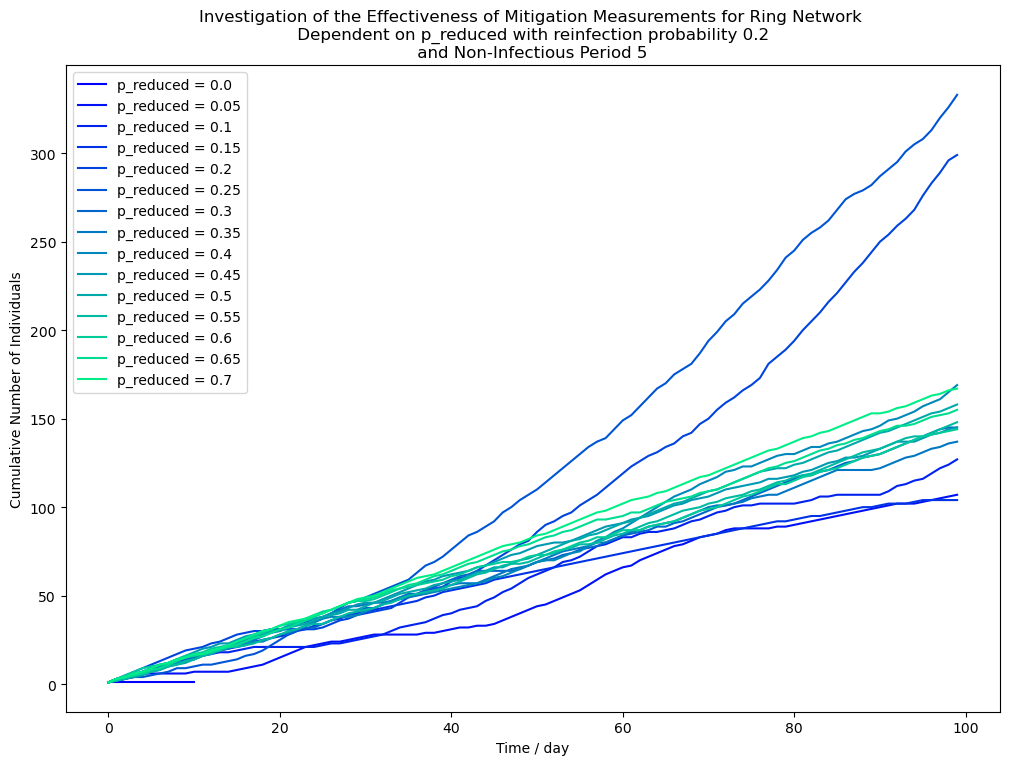

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.59it/s]


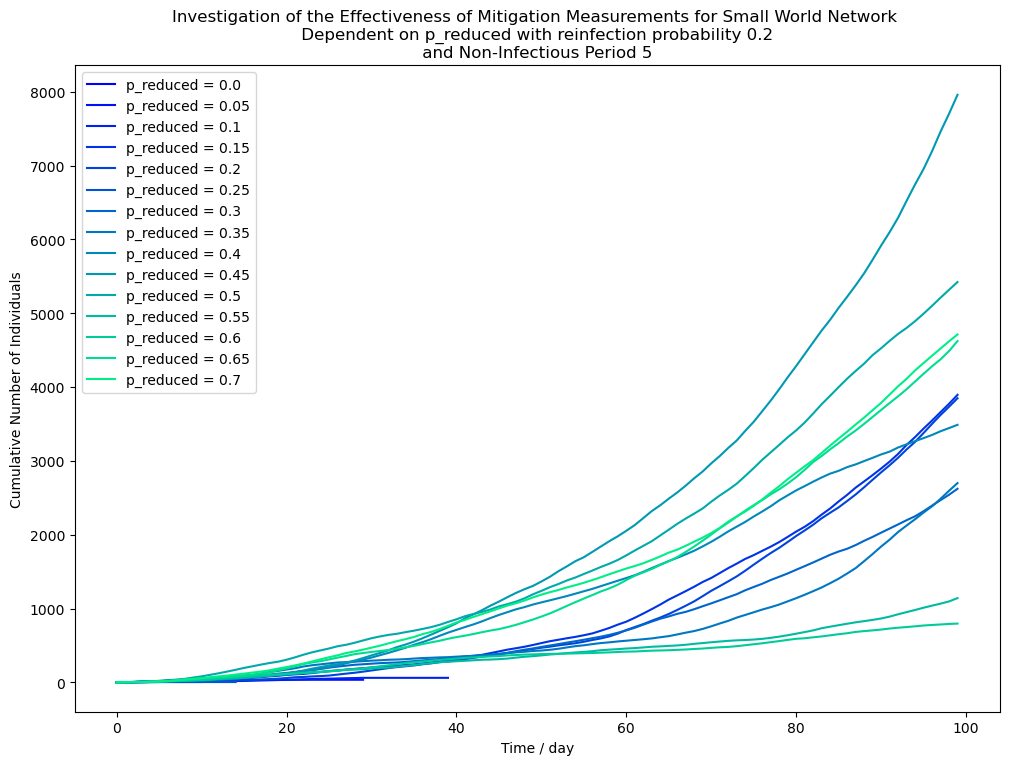

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


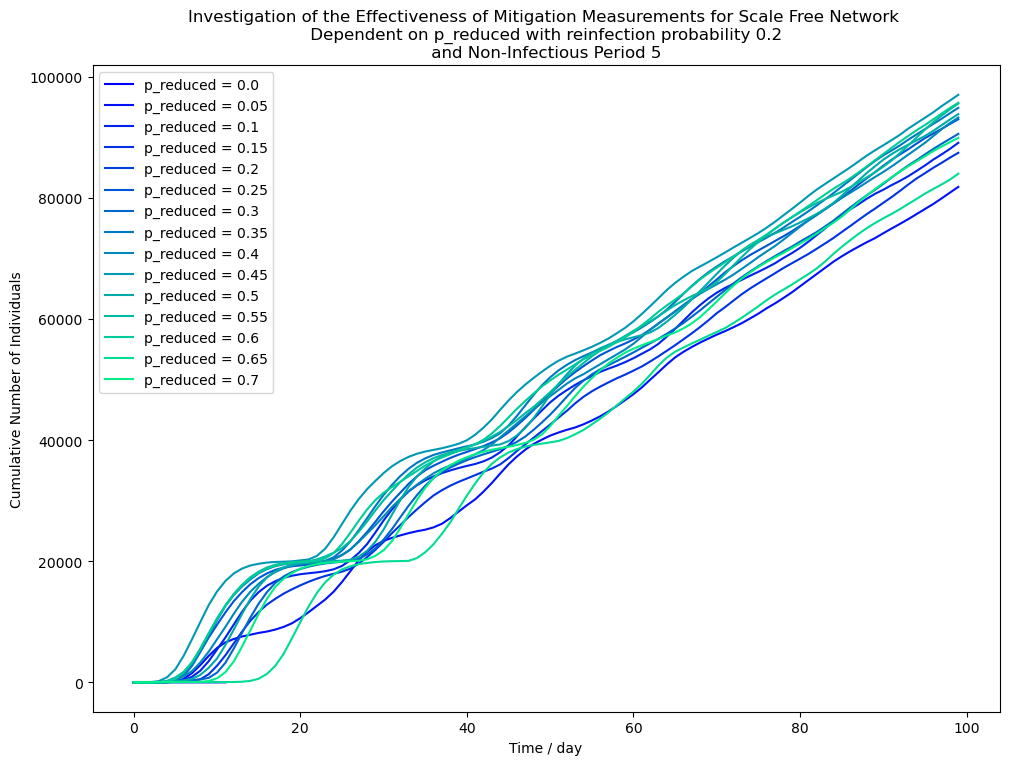

In [47]:
# mitigation_uptakes = [i/20 for i in range(0, 20)]
p = 0.8
# p_reduced = 0.05
p_reduced = [i/20 for i in range(0,15)]
networks = ['Ring', 'Small World', 'Scale Free']

for i in networks:
    plt.figure(figsize = (10,7))
    for j in p_reduced:
        G_data = Pandemic_Network(nodes = 20000, network_type = i, pandemicprob = p, reduced_prob = j, mitigation_proportion = 0.10, NIP = 5, RP = 0.2, sicknode = 1, SW_connections = 3, SW_randomness = 0.5, plots = False, TTR = 10).propagate(100)
        plt.plot(G_data[0], G_data[-2], color = cm.winter(p_reduced.index(j)/len(p_reduced)), label = 'p_reduced = {}'.format(j)) # Cumulative
        # plt.plot(G_data[0], G_data[1], color = cm.seismic(mitigation_uptakes.index(i)/len(mitigation_uptakes)), alpha = 0.5) # Infectious
    plt.legend()
    plt.tight_layout()
    plt.xlabel('Time / day')
    plt.ylabel('Cumulative Number of Individuals')
    plt.title('Investigation of the Effectiveness of Mitigation Measurements for {} Network \n Dependent on p_reduced with reinfection probability 0.2 \n and Non-Infectious Period 5 '.format(i))
    plt.show()

## Affect on Apperance of Waves

100%|█████████████████████████████████████| 1000/1000 [1:54:25<00:00,  6.87s/it]


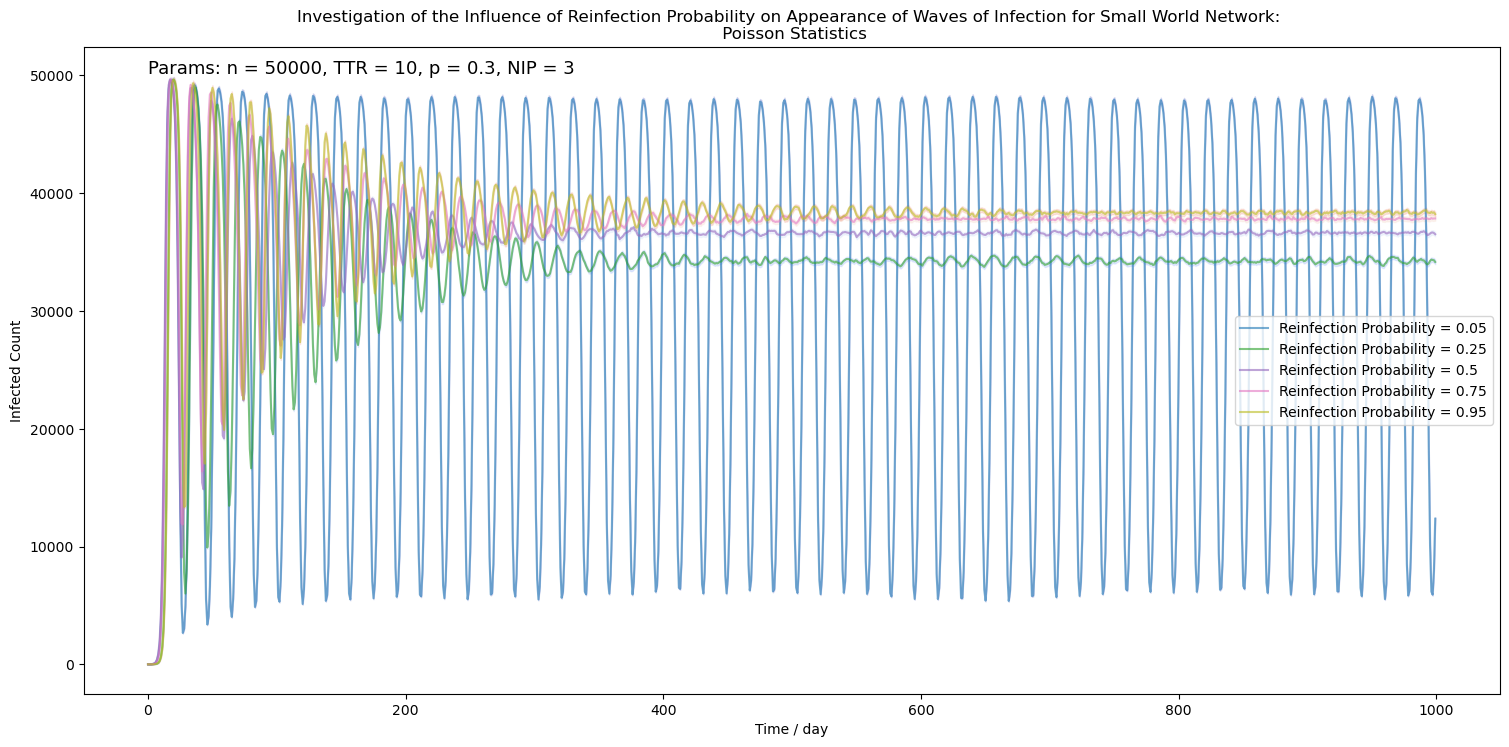

In [60]:
num_nodes = 50000
num_sick = 1
avg_connection = 6
randomness = 0.5
TTR_val = 10
mit_prob = 0.1
mit_proportion = 0
NIP = 3
#RP = 0.5
p = 0.3


# types = ['Ring', 'Small World', 'Scale Free']
ntype = 'Small World'

parameter_vals = [0.05, 0.25, 0.5, 0.75, 0.95] # probability vals
name_of_param = 'Reinfection Probability'

# parameter_vals = [1000, 5000, 10000, 15000, 20000, 25000] # number of nodes
# name_of_param = 'Number of Nodes'

# parameter_vals = [i for i in range(15)] # TTR
# name_of_param = 'TTR'

# parameter_vals = [i for i in range(15)] # Initial Num of Sick Nodes
# name_of_param = 'Initial Number of Sick Nodes'

plt.figure(figsize = (15,7))
for i in parameter_vals:
    G_data = Pandemic_Network(nodes = num_nodes, network_type = ntype, pandemicprob = p, reduced_prob = mit_prob, mitigation_proportion = mit_proportion, NIP = NIP, RP = i, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = False, TTR = TTR_val).propagate(1000)
    upper_lim = [i+np.sqrt(i) for i in G_data[1]]
    lower_lim = [i-np.sqrt(i) for i in G_data[1]]
    # low_lim = [df_inf[0][i] - df_std[i] for i in range(len(df_inf[0]))]
    # high_lim = [df_inf[0][i] + df_std[i] for i in range(len(df_inf[0]))]
    plt.plot(G_data[0], G_data[1], color = cm.tab10(parameter_vals.index(i)/len(parameter_vals)), label = 'Reinfection Probability = {}'.format(i), alpha = 0.6)
    plt.fill_between(G_data[0], lower_lim, upper_lim, color = cm.coolwarm(parameter_vals.index(i)/len(parameter_vals)), alpha = 0.2) # for poisson statistics
    # plt.fill_between(df_time[0], low_lim, high_lim, color = cm.seismic(parameter_vals.index(i)/len(parameter_vals)), alpha = 0.2) # for measurement statistics

plt.legend()
plt.tight_layout()
plt.xlabel('Time / day')
plt.ylabel('Infected Count')
plt.text(0, max(G_data[1])+500, s = 'Params: n = {}, TTR = {}, p = {}, NIP = {}'.format(num_nodes, TTR_val, p, NIP), fontdict=None, fontsize = 13)
plt.title('Investigation of the Influence of {} on Appearance of Waves of Infection for {} Network: \n Poisson Statistics'.format(name_of_param, ntype))
plt.show()

100%|███████████████████████████████████████| 1000/1000 [04:58<00:00,  3.35it/s]


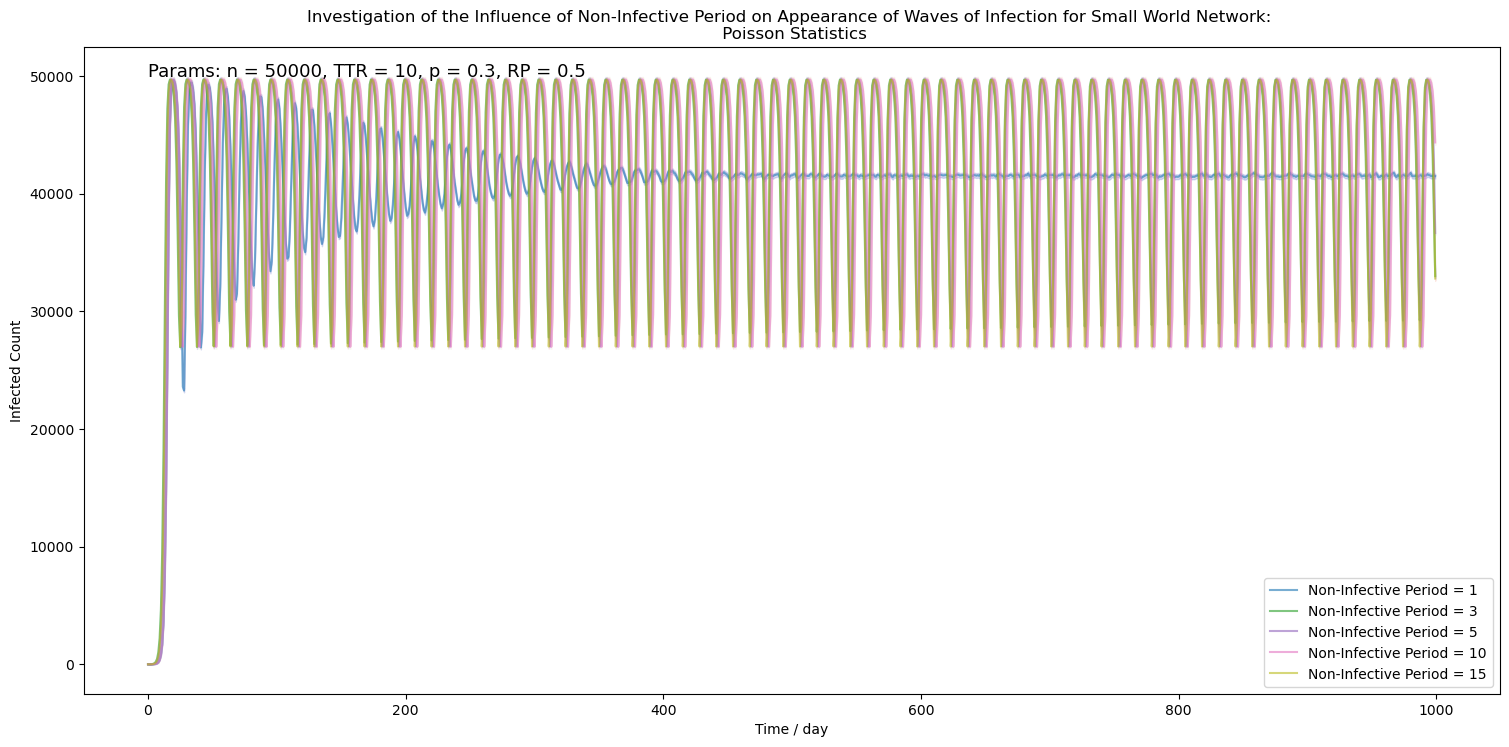

In [61]:
num_nodes = 50000
num_sick = 1
avg_connection = 6
randomness = 0.5
TTR_val = 10
mit_prob = 0.1
mit_proportion = 0
NIP = 2
RP = 0.5
p = 0.3


# types = ['Ring', 'Small World', 'Scale Free']
ntype = 'Small World'

parameter_vals = [1, 3, 5, 10, 15] # probability vals
name_of_param = 'Non-Infective Period'

# parameter_vals = [1000, 5000, 10000, 15000, 20000, 25000] # number of nodes
# name_of_param = 'Number of Nodes'

# parameter_vals = [i for i in range(15)] # TTR
# name_of_param = 'TTR'

# parameter_vals = [i for i in range(15)] # Initial Num of Sick Nodes
# name_of_param = 'Initial Number of Sick Nodes'

plt.figure(figsize = (15,7))
for i in parameter_vals:
    G_data = Pandemic_Network(nodes = num_nodes, network_type = ntype, pandemicprob = p, reduced_prob = mit_prob, mitigation_proportion = mit_proportion, NIP = NIP, RP = i, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = False, TTR = TTR_val).propagate(1000)
    upper_lim = [i+np.sqrt(i) for i in G_data[1]]
    lower_lim = [i-np.sqrt(i) for i in G_data[1]]
    # low_lim = [df_inf[0][i] - df_std[i] for i in range(len(df_inf[0]))]
    # high_lim = [df_inf[0][i] + df_std[i] for i in range(len(df_inf[0]))]
    plt.plot(G_data[0], G_data[1], color = cm.tab10(parameter_vals.index(i)/len(parameter_vals)), label = 'Non-Infective Period = {}'.format(i), alpha = 0.6)
    plt.fill_between(G_data[0], lower_lim, upper_lim, color = cm.coolwarm(parameter_vals.index(i)/len(parameter_vals)), alpha = 0.2) # for poisson statistics
    # plt.fill_between(df_time[0], low_lim, high_lim, color = cm.seismic(parameter_vals.index(i)/len(parameter_vals)), alpha = 0.2) # for measurement statistics

plt.legend()
plt.tight_layout()
plt.xlabel('Time / day')
plt.ylabel('Infected Count')
plt.text(0, max(G_data[1])+250, s = 'Params: n = {}, TTR = {}, p = {}, RP = {}'.format(num_nodes, TTR_val, p, RP), fontdict=None, fontsize = 13)
plt.title('Investigation of the Influence of {} on Appearance of Waves of Infection for {} Network: \n Poisson Statistics'.format(name_of_param, ntype))
plt.show()